In [26]:
print(''' About the dataset

SEPTA - Regional Rail
Predict Arrival Times of Philadelphia's Regional Trains.

SEPTA - Southeastern Pennsylvania Transportation Authority
The SEPTA Regional Rail system consists of commuter rail service on 13 branches to more than 150 active stations in Philadelphia, Pennsylvania, and its suburbs and satellite cities.

SEPTA uses On-Time Performance (OTP) to measure service reliability. OTP identifies the number of trains for all rail lines that arrive at their scheduled destination at the scheduled time. However, by industry standard, a train may arrive up to 5 minutes and 59 seconds after its scheduled time and still be considered on-time.

SEPTA has established an annual goal of 91% for Regional Rail On-Time Performance. How well are they doing? Is it even a meaningful measure?''')

 About the dataset

SEPTA - Regional Rail
Predict Arrival Times of Philadelphia's Regional Trains.

SEPTA - Southeastern Pennsylvania Transportation Authority
The SEPTA Regional Rail system consists of commuter rail service on 13 branches to more than 150 active stations in Philadelphia, Pennsylvania, and its suburbs and satellite cities.

SEPTA uses On-Time Performance (OTP) to measure service reliability. OTP identifies the number of trains for all rail lines that arrive at their scheduled destination at the scheduled time. However, by industry standard, a train may arrive up to 5 minutes and 59 seconds after its scheduled time and still be considered on-time.

SEPTA has established an annual goal of 91% for Regional Rail On-Time Performance. How well are they doing? Is it even a meaningful measure?


In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt
# Impostare le dimensioni della figura con Matplotlib
plt.figure(figsize=(12, 10))
plt.rcParams['figure.figsize'] = (12, 10)

<Figure size 1200x1000 with 0 Axes>

In [15]:
con = create_engine('sqlite:///database.sqlite')

In [16]:
df = pd.read_sql_table('otp', con)
df.head()

,train_id,direction,origin,next_station,date,status,timeStamp
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35


In [17]:
df.describe()

,timeStamp
count,1882015
mean,2016-07-12 04:51:28.591104768
min,2016-03-23 00:01:47
25%,2016-05-12 11:02:27.500000
50%,2016-07-03 13:56:16
75%,2016-09-12 11:34:19
max,2016-11-06 12:17:02


In [18]:
df.status.unique()

array(['1 min', '2 min', 'On Time', '3 min', '7 min', '4 min', '5 min',
       '25 min', '11 min', '6 min', '999 min', '14 min', '13 min',
       '15 min', '8 min', '9 min', '12 min', '16 min', '10 min', '21 min',
       '17 min', '20 min', '18 min', '22 min', '19 min', '24 min',
       '23 min', '29 min', '27 min', '28 min', '26 min', '33 min',
       '42 min', '44 min', '46 min', '68 min', '31 min', '34 min',
       '32 min', '30 min', '36 min', '35 min', '37 min', '39 min',
       '40 min', '38 min', '116 min', '49 min', '48 min', '52 min',
       '53 min', '54 min', '41 min', '50 min', '47 min', '43 min',
       '55 min', '45 min', '51 min', '57 min', '56 min', '60 min',
       '59 min', '62 min', '100 min', '58 min', '69 min', '67 min',
       '75 min', '74 min', '61 min', '119 min', '71 min', '81 min',
       '79 min', '78 min', '73 min', '77 min', '76 min', '63 min',
       '64 min', '90 min', '85 min', '70 min', '72 min', '83 min',
       '66 min', '65 min', '84 min', '82 min',

In [19]:
df[df.status=="1440 min"]

,train_id,direction,origin,next_station,date,status,timeStamp
1034010,9744,N,Roberts Yard,Trenton,2016-07-24,1440 min,2016-07-24 03:10:13


It looks like, in addition to the 999 train suspended code, we have at least one train that is listed as 1440 minutes late (60 days!). It looks like that train should have just been suspended. We'll set that train to the suspended code and then convert the strings to numbers.

In [20]:
df.loc[df.status=="1440 min", "status"] = "999 min"
df['status_n'] = df.status.str.replace("On Time", "0").str.replace(" min","").astype("int")
df.head()

,train_id,direction,origin,next_station,date,status,timeStamp,status_n
0,778,N,Trenton,Stenton,2016-03-23,1 min,2016-03-23 00:01:47,1
1,598,N,Thorndale,Narberth,2016-03-23,1 min,2016-03-23 00:01:58,1
2,279,S,Elm,Ridley Park,2016-03-23,2 min,2016-03-23 00:02:02,2
3,476,N,Airport Terminal E-F,Suburban Station,2016-03-23,On Time,2016-03-23 00:03:19,0
4,474,N,Airport Terminal E-F,Jenkintown-Wyncote,2016-03-23,On Time,2016-03-23 00:03:35,0


Now let's take a look at the distribution, minus the suspended trains:

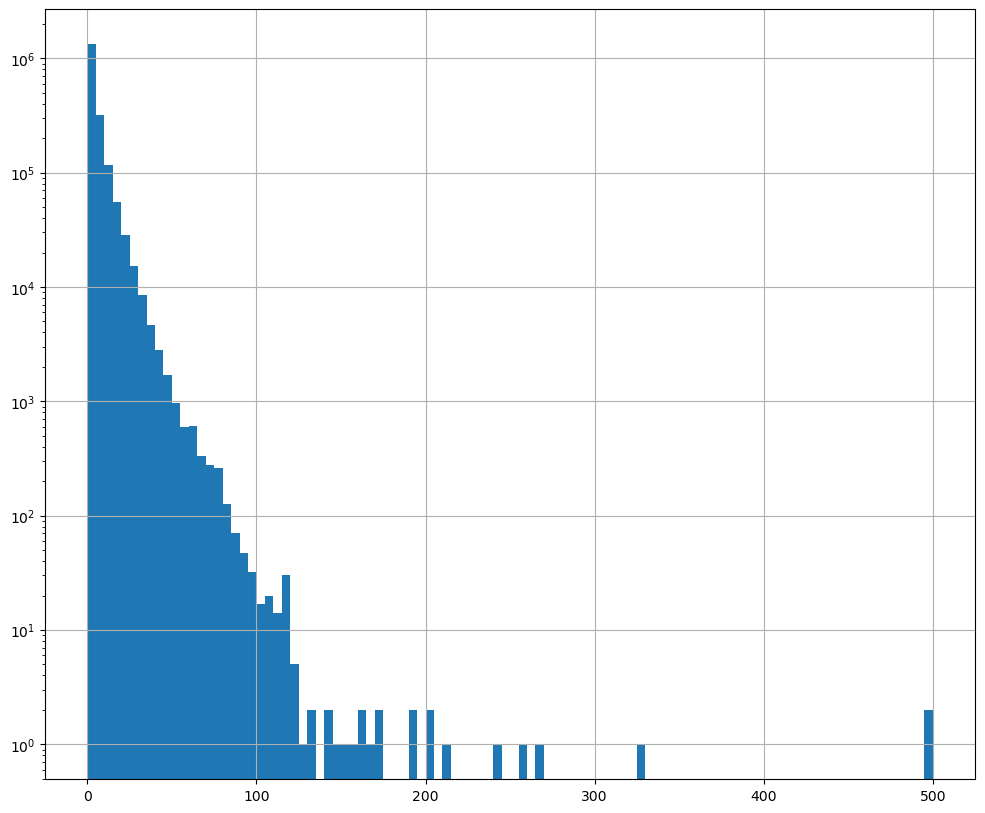

In [21]:
df[df.status_n!=999].status_n.hist(bins=100, log=True);

And then the number of suspended trains:

In [22]:
print("Number of suspended trains:", len(df[df.status_n==999]))

Number of suspended trains: 700


How many trains are "On time" by the definition of less than 6 minutes late? This should give us our first clue into how SEPTA is doing.

In [23]:
# On time trains:
ot = df[df.status_n < 6]
# Late trains:
lt = df[df.status_n >= 6]
print("On time trains:", len(ot), "Late trains:", len(lt), "Percentage on time:", len(ot)/len(df)*100)

On time trains: 1424297 Late trains: 457718 Percentage on time: 75.67936493598616


It looks like SEPTA is at 81% for the spring, about 10% below the stated goal. Can we narrow down some of the problem areas? When do late trains generally occur? We can look at things in terms of a schedule, Day of week vs Time.

In [30]:
df['Day'] = df.timeStamp.dt.dayofweek
df['Hour'] = df.timeStamp.dt.hour
# Assicurati che 'status_n' contenga dati numerici
df['status_n'] = pd.to_numeric(df['status_n'], errors='coerce')

# Raggruppa e somma solo le colonne numeriche
gb = df[df['status_n'].notna() & (df.status_n != 999)].groupby(["Hour", "Day"]).agg({'status_n': 'sum'}).unstack()
gb.head()

status_n                                          
Day         0      1      2      3      4      5      6
Hour                                                   
0       10980  14408  16517  15424  15244  23751  19923
1        1042   2133   2766   3333   2850   5439   6846
2           0    143     28    137   1395    768   1541
3           0     73      0      0      0     94     36
4        1494   1357   1438   1578   1377    748   1016

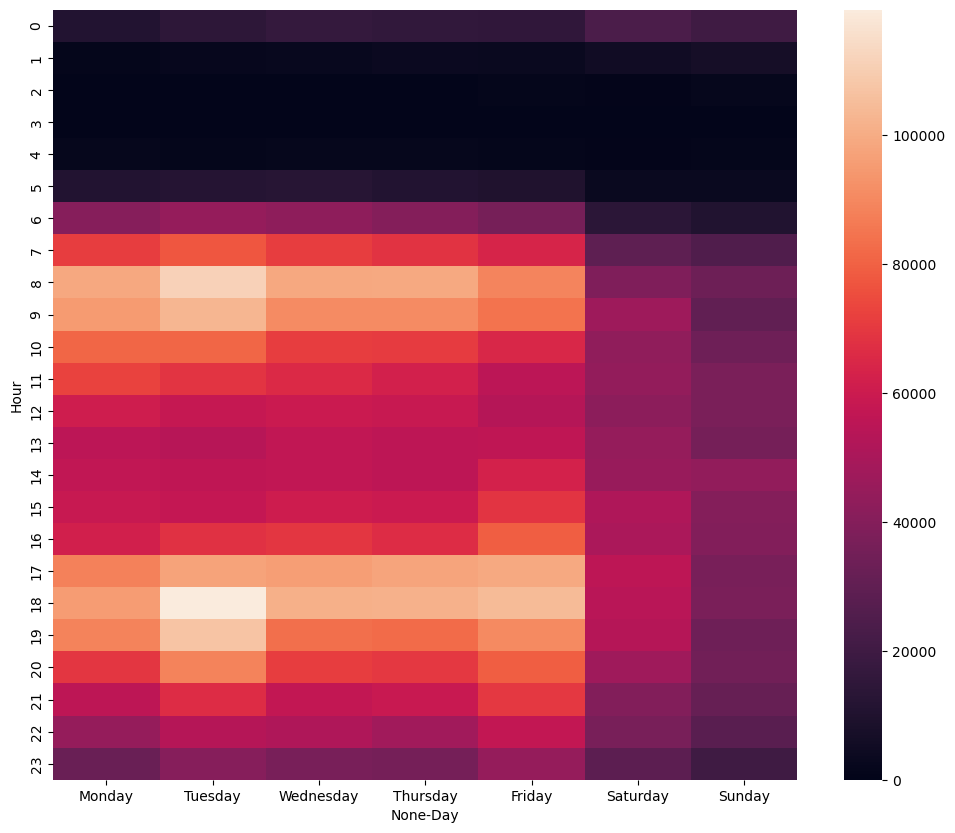

In [31]:
sns.heatmap(gb,xticklabels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

We can see that much of the lateness is generated during rush hour in the week, an expected result.

These are the late trains but what are the real late trains, as defined by SEPTA? What is the distribution of trains > 5 minutes late?

In [33]:
lt = df[(df['status_n'] >= 6) & (df['status_n'].notna() & (df.status_n != 999))]
gb2 = lt.groupby(["Hour", "Day"]).agg({'status_n': 'sum'}).unstack()


gb2.head()

status_n                                                      
Day         0        1        2        3        4        5        6
Hour                                                               
0      8092.0  10354.0  12456.0  11193.0  10876.0  18195.0  15169.0
1       934.0   1384.0   1983.0   2403.0   1961.0   4412.0   5106.0
2         NaN    143.0     28.0    137.0   1395.0    762.0    941.0
3         NaN     73.0      NaN      NaN      NaN     94.0     30.0
4       477.0    436.0    487.0    612.0    382.0    187.0    348.0

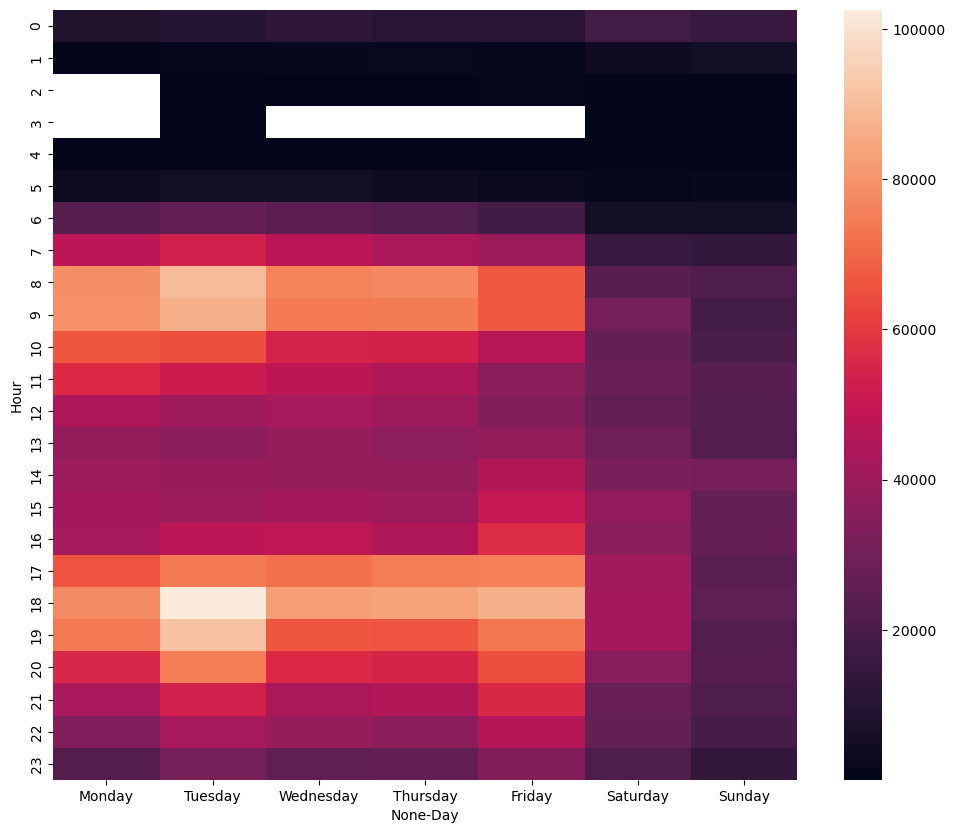

In [34]:
sns.heatmap(gb2,xticklabels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

Looks very similar. What is it about Tuesday morning rush hour anyways?